In [18]:
import matplotlib.pylab as plt
import cv2
import numpy as np
import math
import sys
np.set_printoptions(threshold=sys.maxsize)
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    #channel_count = img.shape[2]
    match_mask_color = 255
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def drow_the_lines(img, lines):
    img = np.copy(img)
    height = img.shape[0]
    blank_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    for line in lines:
        for x1, y1, x2, y2 in line:
                k=math.atan((y2-y1)/(x2-x1))
                l = math.sqrt(math.pow((x2 - x1), 2) + math.pow((y2 - y1), 2))
                if ((0.7<k<2.61) or (-2.61<k<-0.7)) and l > height/3 :
                    cv2.line(blank_image, (x1-40,y1-40), (x2-40,y2-40), (0, 255, 0), thickness=10)

    img = cv2.addWeighted(img, 0.8, blank_image, 1, 0.0)
    return img
def deep_teknique(image):
    (H, W) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(W, H),
        swapRB=False, crop=False)
    net = cv2.dnn.readNetFromCaffe('deploy.prototxt', 
                                   'hed_pretrained_bsds.caffemodel')
    net.setInput(blob)
    hed = net.forward()
    hed = cv2.resize(hed[0, 0], (W, H))
    hed = (255 * hed).astype("uint8")
    return hed

def process(image):
    #image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    height = image.shape[0]
    width = image.shape[1]
    region_of_interest_vertices = [
        (40, height),
        (width/2-100, 70),(width/2+100, 70),
        (width, height)
    ]
    kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_sharp = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
    bilateral_image = cv2.bilateralFilter(image_sharp, 9, 95, 75)
    
    deep = deep_teknique(bilateral_image)
    canny_image = cv2.Canny(deep, 75, 150)
    kernel = np.ones((5, 5), np.uint8)
    edges_dilated = cv2.dilate(canny_image, kernel)
    cropped_image = region_of_interest(canny_image,
                    np.array([region_of_interest_vertices], np.int32),)
    lines = cv2.HoughLinesP(edges_dilated, rho=1, theta=np.pi/360, threshold=100, minLineLength =10, 
                            maxLineGap=2)
    bundler = HoughBundler(min_distance=5,min_angle=15)
    line = bundler.process_lines(lines)
    result = drow_the_lines(image,line)
    plt.imshow(canny_image)
    plt.show()
    plt.imshow(deep)
    plt.show()
    k=1
    cv2.imwrite('deep2.jpg',deep)
    cv2.imwrite('canny2.jpg',canny_image)
    cv2.imwrite('final2.jpg',result)
    return result

    




In [2]:
class HoughBundler:     
    def __init__(self,min_distance=5,min_angle=2):
        self.min_distance = min_distance
        self.min_angle = min_angle
    
    def get_orientation(self, line):
        orientation = math.atan2(abs((line[3] - line[1])), abs((line[2] - line[0])))
        return math.degrees(orientation)

    def check_is_line_different(self, line_1, groups, min_distance_to_merge, min_angle_to_merge):
        for group in groups:
            for line_2 in group:
                if self.get_distance(line_2, line_1) < min_distance_to_merge:
                    orientation_1 = self.get_orientation(line_1)
                    orientation_2 = self.get_orientation(line_2)
                    if abs(orientation_1 - orientation_2) < min_angle_to_merge:
                        group.append(line_1)
                        return False
        return True

    def distance_point_to_line(self, point, line):
        px, py = point
        x1, y1, x2, y2 = line

        def line_magnitude(x1, y1, x2, y2):
            line_magnitude = math.sqrt(math.pow((x2 - x1), 2) + math.pow((y2 - y1), 2))
            return line_magnitude

        lmag = line_magnitude(x1, y1, x2, y2)
        if lmag < 0.00000001:
            distance_point_to_line = 9999
            return distance_point_to_line

        u1 = (((px - x1) * (x2 - x1)) + ((py - y1) * (y2 - y1)))
        u = u1 / (lmag * lmag)

        if (u < 0.00001) or (u > 1):
            #// closest point does not fall within the line segment, take the shorter distance
            #// to an endpoint
            ix = line_magnitude(px, py, x1, y1)
            iy = line_magnitude(px, py, x2, y2)
            if ix > iy:
                distance_point_to_line = iy
            else:
                distance_point_to_line = ix
        else:
            # Intersecting point is on the line, use the formula
            ix = x1 + u * (x2 - x1)
            iy = y1 + u * (y2 - y1)
            distance_point_to_line = line_magnitude(px, py, ix, iy)

        return distance_point_to_line

    def get_distance(self, a_line, b_line):
        dist1 = self.distance_point_to_line(a_line[:2], b_line)
        dist2 = self.distance_point_to_line(a_line[2:], b_line)
        dist3 = self.distance_point_to_line(b_line[:2], a_line)
        dist4 = self.distance_point_to_line(b_line[2:], a_line)

        return min(dist1, dist2, dist3, dist4)

    def merge_lines_into_groups(self, lines):
        groups = []  # all lines groups are here
        # first line will create new group every time
        groups.append([lines[0]])
        # if line is different from existing gropus, create a new group
        for line_new in lines[1:]:
            if self.check_is_line_different(line_new, groups, self.min_distance, self.min_angle):
                groups.append([line_new])

        return groups

    def merge_line_segments(self, lines):
        orientation = self.get_orientation(lines[0])
      
        if(len(lines) == 1):
            return np.block([[lines[0][:2], lines[0][2:]]])

        points = []
        for line in lines:
            points.append(line[:2])
            points.append(line[2:])
        if 45 < orientation <= 90:
            #sort by y
            points = sorted(points, key=lambda point: point[1])
        else:
            #sort by x
            points = sorted(points, key=lambda point: point[0])

        return np.block([[points[0],points[-1]]])

    def process_lines(self, lines):
        lines_horizontal  = []
        lines_vertical  = []
  
        for line_i in [l[0] for l in lines]:
            orientation = self.get_orientation(line_i)
            # if vertical
            if 45 < orientation <= 90:
                lines_vertical.append(line_i)
            else:
                lines_horizontal.append(line_i)

        lines_vertical  = sorted(lines_vertical , key=lambda line: line[1])
        lines_horizontal  = sorted(lines_horizontal , key=lambda line: line[0])
        merged_lines_all = []

        # for each cluster in vertical and horizantal lines leave only one line
        for i in [lines_horizontal, lines_vertical]:
            if len(i) > 0:
                groups = self.merge_lines_into_groups(i)
                merged_lines = []
                for group in groups:
                    merged_lines.append(self.merge_line_segments(group))
                merged_lines_all.extend(merged_lines)
                    
        return np.asarray(merged_lines_all)

# Usage:
# lines = cv.HoughLinesP(edges, 1, np.pi / 180, 50, None, 50, 10)
# bundler = HoughBundler(min_distance=10,min_angle=5)
# lines = bundler.process_lines(lines)


C:\Users\ironb\AppData\Local\Temp\ipykernel_15100\947518767.py:22: RuntimeWarning: divide by zero encountered in int_scalars
  k=math.atan((y2-y1)/(x2-x1))


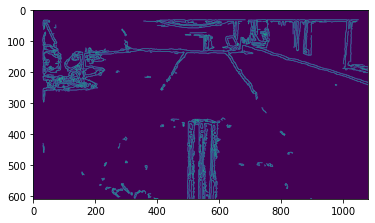

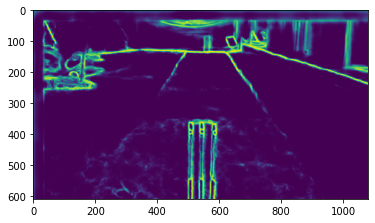

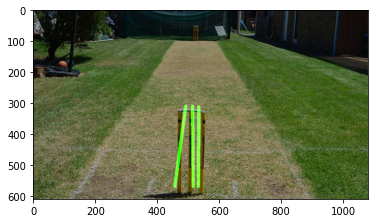

In [25]:
pop = cv2.imread(r'C:/env/yo8.jpg')
result = process(pop)
plt.imshow(result)


